## Machine Learning Analysis using Coffee Sales and Weather Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine


In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [3]:
load_dotenv()

DB_NAME = os.getenv("MYSQL_DATABASE")
DB_USER = os.getenv("MYSQL_USER")
DB_PASSWORD = os.getenv("MYSQL_PASSWORD")
DB_HOST = "127.0.0.1"
DB_PORT = 3306

In [4]:
engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


Read coffee sales data from MySQL running inside Docker

In [5]:
coffe_data = pd.read_sql(
    sql="SELECT * FROM coffee_sales",
    con=engine
)

In [6]:
coffe_data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,total_sales,month,hour,weekday
0,1,2023-01-01,0 days 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,2023-01,7,Sunday
1,2,2023-01-01,0 days 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,2023-01,7,Sunday
2,3,2023-01-01,0 days 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,2023-01,7,Sunday
3,4,2023-01-01,0 days 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0,2023-01,7,Sunday
4,5,2023-01-01,0 days 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,2023-01,7,Sunday


In [7]:
coffe_data.rename(columns={'transaction_date':'date'},inplace=True)
coffe_data.head()

,transaction_id,date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,total_sales,month,hour,weekday
0,1,2023-01-01,0 days 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,2023-01,7,Sunday
1,2,2023-01-01,0 days 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,2023-01,7,Sunday
2,3,2023-01-01,0 days 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,2023-01,7,Sunday
3,4,2023-01-01,0 days 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0,2023-01,7,Sunday
4,5,2023-01-01,0 days 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,2023-01,7,Sunday


## Calculates total sales per store for each day
Daily Total Sales by 
Transaction-level sales data is grouped by date and store_id
in order to match the daily granularity of the weather dataset
before merging sales data with weather data

In [8]:
daily_sales = coffe_data.groupby ( ["date", "store_id"] ).agg(
    { "total_sales": "sum"}).reset_index()
daily_sales

,date,store_id,total_sales
0,2023-01-01,3,868.40
1,2023-01-01,5,788.35
2,2023-01-01,8,851.45
3,2023-01-02,3,925.50
4,2023-01-02,5,649.05
...,...,...,...
538,2023-06-29,5,1299.45
539,2023-06-29,8,1298.55
540,2023-06-30,3,1807.65
541,2023-06-30,5,1768.74


 Read daily_weather data from MySQL running inside Docker

In [9]:
weather_data= pd.read_sql(
    sql="SELECT * FROM daily_weather",
    con=engine
)

In [10]:
weather_data.head()

,date,temperature_2m_mean
0,2023-01-01,8.78542
1,2023-01-02,7.98125
2,2023-01-03,9.69167
3,2023-01-04,13.08130
4,2023-01-05,9.91250


In [11]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 181 non-null    object 
 1   temperature_2m_mean  181 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [12]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         543 non-null    datetime64[ns]
 1   store_id     543 non-null    object        
 2   total_sales  543 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 12.9+ KB


# Convert date columns to datetime for merging

In [13]:
weather_data['date'] = pd.to_datetime(weather_data['date'])
daily_sales['date']=pd.to_datetime(daily_sales['date'])

 Merge datasets to create a unified dataset for machine learning analysis


In [14]:
data_ml=pd.merge(daily_sales,weather_data,on='date',how='left')

In [15]:
data_ml.head()

,date,store_id,total_sales,temperature_2m_mean
0,2023-01-01,3,868.40,8.78542
1,2023-01-01,5,788.35,8.78542
2,2023-01-01,8,851.45,8.78542
3,2023-01-02,3,925.50,7.98125
4,2023-01-02,5,649.05,7.98125


Extract year, month, and day from the date column                                                                                   
These features are created from the date to be used as input variables in the machine learning model



In [16]:
data_ml['year'] = data_ml['date'].dt.year
data_ml['month_num'] = data_ml['date'].dt.month
data_ml['day_num'] = data_ml['date'].dt.day

In [ ]:
data_ml.head()

,date,store_id,total_sales,temperature_2m_mean,year,month_num,day_num
0,2023-01-01,3,868.40,8.78542,2023,1,1
1,2023-01-01,5,788.35,8.78542,2023,1,1
2,2023-01-01,8,851.45,8.78542,2023,1,1
3,2023-01-02,3,925.50,7.98125,2023,1,2
4,2023-01-02,5,649.05,7.98125,2023,1,2
...,...,...,...,...,...,...,...
538,2023-06-29,5,1299.45,22.35420,2023,6,29
539,2023-06-29,8,1298.55,22.35420,2023,6,29
540,2023-06-30,3,1807.65,23.03960,2023,6,30
541,2023-06-30,5,1768.74,23.03960,2023,6,30


In [18]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 543 non-null    datetime64[ns]
 1   store_id             543 non-null    object        
 2   total_sales          543 non-null    float64       
 3   temperature_2m_mean  543 non-null    float64       
 4   year                 543 non-null    int32         
 5   month_num            543 non-null    int32         
 6   day_num              543 non-null    int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(1)
memory usage: 23.5+ KB


Feature Selection for Machine Learning Model
Selected time, weather, and store-related features as model inputs
total_sales is defined as the target variable for prediction


In [19]:
df_model =data_ml[["year",
    
    "month_num",
    "day_num",
    "temperature_2m_mean",
    "store_id",
    "total_sales"
]]


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 543 non-null    int32  
 1   month_num            543 non-null    int32  
 2   day_num              543 non-null    int32  
 3   temperature_2m_mean  543 non-null    float64
 4   store_id             543 non-null    object 
 5   total_sales          543 non-null    float64
dtypes: float64(2), int32(3), object(1)
memory usage: 19.2+ KB


In [22]:

from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [23]:
X = df_model.drop("total_sales", axis=1)
y = df_model["total_sales"]


 Train-Test Split for Model Training and Evaluation
 Split the dataset into training and testing sets
 to train the model and evaluate its performance on unseen data


In [24]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regression Model
Initialize and train the Random Forest model using the training dataset
to learn complex and non-linear patterns in the sales data


In [25]:

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

# Model Evaluation Metrics
Evaluate the Random Forest model performance using regression metrics
MSE and RMSE measure prediction error, while R² shows explained variance

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R2 Score:",r_squared)
print('RMSE:',rmse)



MSE: 42369.749533091875
R2 Score: 0.7969523224209241
RMSE: 205.83913508633842


Model Performance Interpretation:
 R² ≈ 0.80 indicates that the model explains around 80% of the variability 
#in total sales, which demonstrates strong predictive capability.
#
 RMSE (~206) represents the average prediction error in actual sales units.
 Considering the natural fluctuations in daily sales, this error level is reasonable
 and acceptable for practical business use.
#
 MSE (~42,370) is the mean of squared prediction errors. While the value appears large,
 it is expected due to error squaring and is primarily useful for comparing 
 different models rather than direct interpretation.
#
 Overall, the Random Forest model effectively captures non-linear relationships
 and provides reliable performance for sales forecasting tasks.


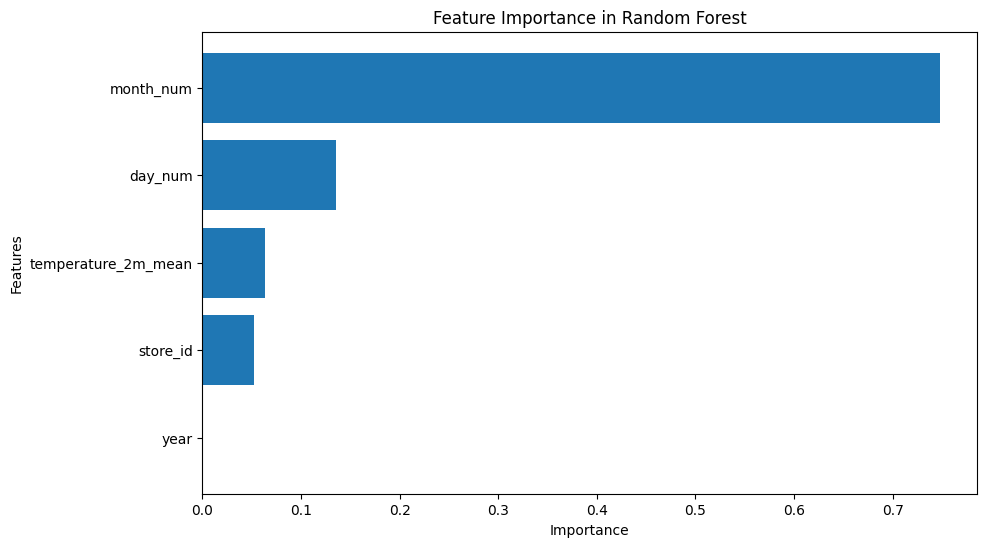

In [27]:
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()


 Feature Importance Interpretation:                                     
 The Random Forest model shows that month, day, and store_id are the main factors influencing sales predictions.                  
 Temperature has minor impact, while year has no effect since the dataset contains only one year.
 This helps us understand which variables the model relies on most for forecasting.


In [28]:
X_test['prediction']=y_pred.round(2)
X_test['actual_values']=y_test

Compare predicted sales with actual values to see model error. 
Differences are normal as the model estimates, not reproduces, real sales.


In [29]:
X_test.head()

,year,month_num,day_num,temperature_2m_mean,store_id,prediction,actual_values
530,2023,6,26,21.7875,8,1814.87,1746.10
478,2023,6,9,16.9417,5,1795.75,2159.08
354,2023,4,29,10.8188,3,1060.40,1124.05
531,2023,6,27,21.7583,3,2115.05,1861.55
322,2023,4,18,11.0167,5,1465.78,1164.68


# Random Forest: Actual vs Predicted Total Sales
 This plot compares the actual total sales (y_test) with the predicted sales (y_pred) 
 from the trained Random Forest model.                                                
 The red dashed line represents the ideal case where predicted values equal actual values.                                           
 Points close to the line indicate accurate predictions, while points farther away show prediction errors.

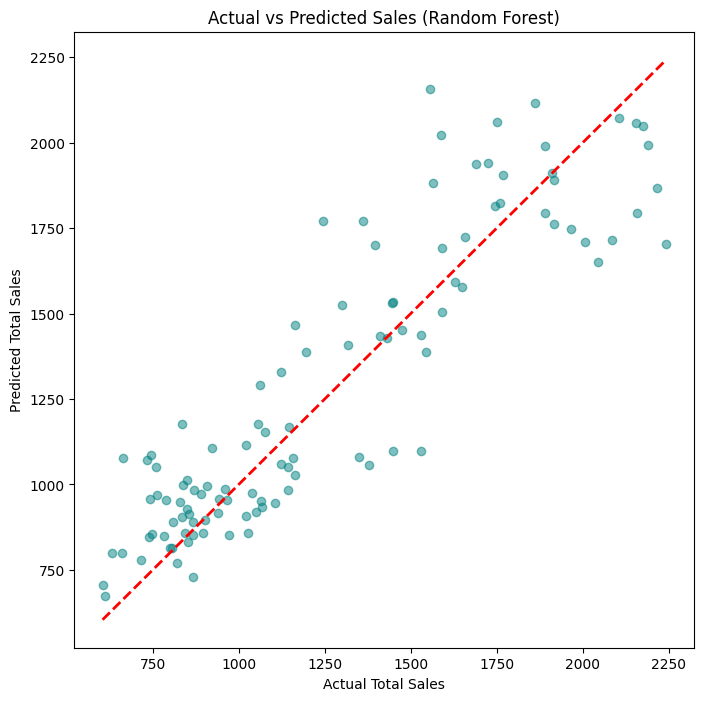

In [32]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal xətt
plt.xlabel("Actual Total Sales")
plt.ylabel("Predicted Total Sales")
plt.title("Actual vs Predicted Sales (Random Forest)")
plt.show()

In [31]:
# Future Sales Prediction for July 1, 2023
# Columns order must match the training features

stores = df_model['store_id'].unique()

future_day = pd.DataFrame({
    'year': [2023]*len(stores),
    'month_num': [7]*len(stores),
    'day_num': [1]*len(stores),
    'temperature_2m_mean': [30.0]*len(stores),
    'store_id': stores
})

# Reorder columns exactly as in training
future_day = future_day[["year", "month_num", "day_num", "temperature_2m_mean", "store_id"]]

# Predict sales
future_day['predicted_sales'] = rf_model.predict(future_day)

future_day


,year,month_num,day_num,temperature_2m_mean,store_id,predicted_sales
0,2023,7,1,30.0,3,1775.602350
1,2023,7,1,30.0,5,1572.711517
2,2023,7,1,30.0,8,1732.437800
